In [1]:
from collections import Counter
import math
import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np

sys.path.insert(1, './setup/')
from gp.hw.program import Program
from gp.contexts.symbolic_regression.primitive_sets import \
    nicolau_a, nicolau_b, nicolau_c

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams['figure.figsize'] = 5.85, 4.135
# matplotlib.rcParams['figure.figsize'] = 11.7, 8.27
# style.use('seaborn-poster')

# Useful directory paths.
root_dir = f'{os.getcwd()}/../results'
graphics_dir = f'{root_dir}/graphics'

# GP tools.
tools = ('DEAP', 'TensorGP (CPU)', 'TensorGP (GPU)', 'Operon', 'FPGA')
# tools = ('DEAP', 'Operon', 'FPGA')

# Primitive sets.
primitive_sets = {
    'nicolau_a': nicolau_a,
    'nicolau_b': nicolau_b,
    'nicolau_c': nicolau_c,
}

# Program tree depth constraints for each primitive set.
d = (9, 7, 7)

# Numbers of fitness cases.
n_fitness_cases = (10, 100, 1000, 10000, 100000)
# n_fitness_cases = (10, 100,)

# Number of program bins.
n_bins = 32

# Number of programs per bin.
n_programs = 512

# Number of times in which experiments are run.
n_runs = 11

In [2]:
# Load programs and input/target data.
with open(f'{root_dir}/programs.pkl', 'rb') as f:
    programs = pickle.load(f)
with open(f'{root_dir}/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open(f'{root_dir}/target.pkl', 'rb') as f:
    target = pickle.load(f)
inputs = np.asarray(inputs)
target = np.asarray(target)

### Compute some statistics for the set of random programs generated for each primitive set.

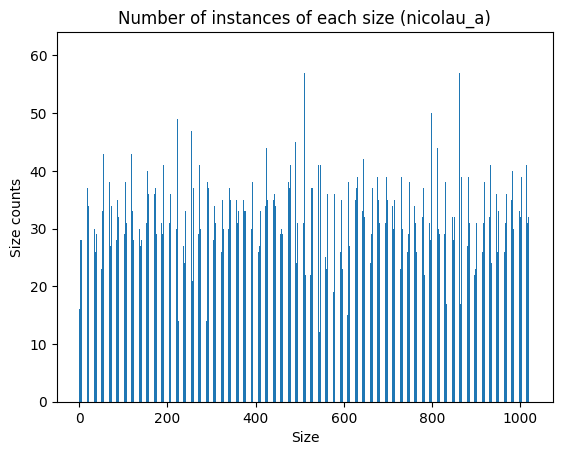

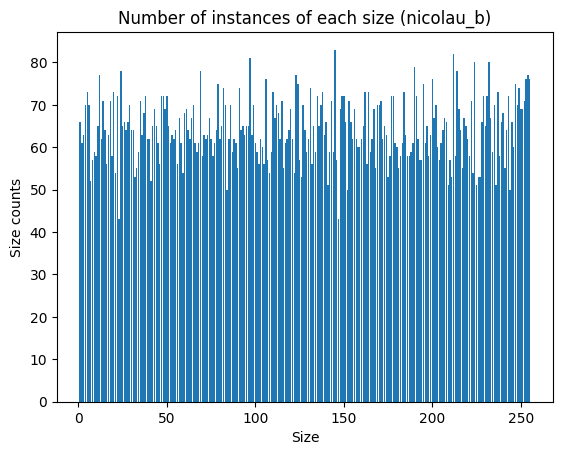

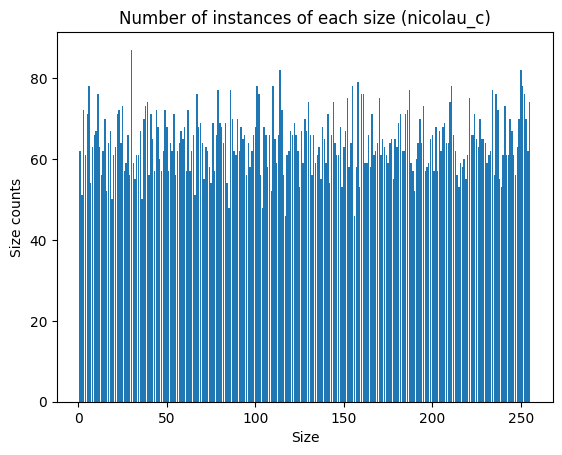



Number of nodes: [[[      87820      251700      411800      580620      741580
        905080     1068740     1233600     1390640     1558000
       1726640     1886260     2050920     2216940     2380080
       2544380     2706700     2872080     3035760     3201140
       3363720     3525220     3693240     3857440     4018120
       4179080     4347580     4511440     4676700     4835540
       5002220     5163800]
  [     878200     2517000     4118000     5806200     7415800
       9050800    10687400    12336000    13906400    15580000
      17266400    18862600    20509200    22169400    23800800
      25443800    27067000    28720800    30357600    32011400
      33637200    35252200    36932400    38574400    40181200
      41790800    43475800    45114400    46767000    48355400
      50022200    51638000]
  [    8782000    25170000    41180000    58062000    74158000
      90508000   106874000   123360000   139064000   155800000
     172664000   188626000   205092000   22

In [3]:
# Sizes of each program for every program bin, for each primitive set.
sizes = []

# Total number of nodes for each program bin, for each
# number of fitness cases, for each primitive set.
n_nodes = []

for (name, ps), d_ in zip(primitive_sets.items(), d):
    # For each primitive set...

    # Depth/size constraints relevant to primitive set.
    d_min = 0
    d_max = d_
    s_min = 1
    s_max = Program.max_size(ps.m, d_max)
    
    # Size statistics relevant to primitive set.
    sizes.append([])
    for i, program_bin in enumerate(programs[name]):
        # For each program bin...
        sizes_ = [len(p) for p in program_bin]
        sizes[-1].extend(sizes_)

    n_nodes.append([[nfc * sum(sizes[-1][n_programs * i : n_programs * (i+1)])
        for i in range(n_bins)] for nfc in n_fitness_cases])

    # Plot program size distribution across all program bins.
    c = Counter(sizes[-1])
    sizes_ = [c[s] if s in c else 0 for s in range(s_min, s_max + 1)]
    plt.bar(range(s_min, s_max + 1), sizes_)
    plt.xlabel('Size')
    plt.ylabel('Size counts')
    plt.title('Number of instances of each size ('+name+')')
    # plt.savefig(f'{graphics_dir}/{name}/sizes.png')
    # plt.savefig(f'{graphics_dir}/{name}/sizes.svg')
    plt.show()

# Convert `n_nodes` to NumPy array.
n_nodes = np.asarray(n_nodes)
print(f'\n\nNumber of nodes: {n_nodes}\n\n')

### Extract runtimes for all experiments, for each GP tool.

In [4]:
# Runtimes for each program bin, for each number of fitness 
# cases, for each primitive set, for each tool.
runtimes = []

# Load runtimes for DEAP.
with open(f'{root_dir}/runtimes/deap/results.pkl', 'rb') as f:
    runtimes_ = pickle.load(f)
runtimes.append(np.tile(
    np.array([[[r for r in runtimes_[i][j]] for j in range(
    len(n_fitness_cases))] for i in range(len(primitive_sets))]),
    (1, 1, 1, n_runs)))

# Load runtimes for TensorGP, CPU.
with open(f'{root_dir}/runtimes/tensorgp/results_cpu.pkl', 'rb') as f:
    runtimes_ = pickle.load(f)
runtimes.append(np.array(
    [[[r for r in runtimes_[i][j]] for j in range(
    len(n_fitness_cases))] for i in range(len(primitive_sets))]))

# Load runtimes for TensorGP, GPU.
with open(f'{root_dir}/runtimes/tensorgp/results_gpu.pkl', 'rb') as f:
    runtimes_ = pickle.load(f)
runtimes.append(np.array(
    [[[r for r in runtimes_[i][j]] for j in range(
    len(n_fitness_cases))] for i in range(len(primitive_sets))]))

# Load runtimes for Operon.
runtimes_ = []
for name in primitive_sets:
    # For each primitive set...
    runtimes_.append([])
    with open(f'{root_dir}/runtimes/operon/{name}.csv', 'r') as f:
        lines = f.readlines()
    for nfc in n_fitness_cases:
        # For each number of fitness cases...
        runtimes_[-1].append([])
        # Index offset into the `lines` list.
        i = (int(math.log(nfc, 10)) - 1) * n_bins
        for j in range(1, n_bins + 1):
            # For each program bin...
            # String representing runtimes for bin `j`, 
            # in terms of microseconds.
            s = ''.join(lines[i + j - 1].split())
            runtimes_[-1][-1].append([float(r)/(10**6) for r in s.split(',')])
runtimes.append(np.array(runtimes_))

# Load runtimes for the FPGA architecture.
clock_freq = []
runtimes_ = []
for name in primitive_sets:
    # For each primitive set...
    runtimes_.append([])
    clock_freq.append([])
    for nfc in n_fitness_cases:
        # For each number of fitness cases...
        clock_freq[-1].append([])
        with open(f'{root_dir}/runtimes/fpga/{name}/{nfc}.txt', 'r') as f:
            # Lines of the current file.
            lines = f.readlines()
            # Clock frequency for the relevant run.
            clock_freq[-1][-1] = float(lines[0])*1e6
            # Runtimes relevant to the number of fitness cases.
            runtimes_[-1].append([[float(n_cycles) / clock_freq[-1][-1]] 
                for n_cycles in lines[1:]])
runtimes.append(np.tile(np.array(runtimes_), (1, 1, 1, n_runs)))

# Clock frequencies for FPGA.
print(f'FPGA clock frequencies: {clock_freq}')
print(f'\nAverage FPGA clock frequencies: {np.mean(clock_freq)}')

# Convert the tool runtimes to a NumPy array.
runtimes = np.stack([r for r in runtimes])

# Median runtimes for each program bin, for each number of fitness 
# cases, for each primitive set, for each tool, for each function set.
median_runtimes = [[[[np.median(runtimes[i][j][k][l]) 
    for l in range(n_bins)]
    for k in range(len(n_fitness_cases))] 
    for j in range(len(primitive_sets))]
    for i in range(len(tools))]
median_runtimes = np.asarray(median_runtimes)

# Compute node evaluations per second (NEPS) for each runtime, 
# for each program bin, for each number of fitness cases, for each 
# primitive set, for each tool.
neps = np.array([[[np.tile(n_nodes[j][k], (n_runs, 1)).T / runtimes[i][j][k]
    for k in range(len(n_fitness_cases))]
    for j in range(len(primitive_sets))] 
    for i in range(len(tools))])

# Median NEPS for each program bin, for each number of fitness 
# cases, for each primitive set, for each tool.
# (Note that, for each program bin, the following calculation is 
# equivalent to dividing the relevant number of nodes within each 
# program bin by the relevant median runtime corresponding to the bin.)
median_neps = [[[[np.median(neps[i][j][k][l]) 
    for l in range(n_bins)]
    for k in range(len(n_fitness_cases))] 
    for j in range(len(primitive_sets))]
    for i in range(len(tools))]
median_neps = np.asarray(median_neps)


# Maximum of median NEPS, for each number of fitness 
# cases, for each primitive set, for each tool.
max_neps_args = np.argmax(np.max(median_neps, axis=3), axis=0)
max_neps = np.max(np.max(median_neps, axis=3), axis=0)
print(f'\nMaximum of median NEPS values:\n{max_neps}')
print(f'\nTool achieving max NEPS value:\n{max_neps_args}')

FPGA clock frequencies: [[194000000.0, 191000000.0, 189000000.0, 197000000.0, 170000000.0], [189000000.0, 190000000.0, 185000000.0, 197000000.0, 184000000.0], [163000000.0, 159000000.0, 159000000.0, 148000000.0, 154000000.0]]

Average FPGA clock frequencies: 177933333.33333334

Maximum of median NEPS values:
[[3.58834316e+09 3.40337060e+10 3.40337060e+11 1.98547686e+11
  1.96909056e+11]
 [2.06512886e+09 1.82806653e+10 1.82806653e+11 1.36407622e+11
  1.46574631e+11]
 [1.85677065e+09 1.88310838e+10 1.88310838e+11 1.26199545e+11
  1.62068759e+11]]

Tool achieving max NEPS value:
[[3 3 3 4 3]
 [3 3 3 3 3]
 [3 3 3 3 3]]


### Compute an average FPGA speedup (in terms of NEPS) across all program bins, for an increasing sequence of "number of fitness case" thresholds.

In [5]:
# Total median runtimes across all primitive sets, 
# for each fitness case threshold, for each tool.
total_median_runtimes = np.asarray(
    [[np.sum(median_runtimes[t, :, :n+1])
        for n, _ in enumerate(n_fitness_cases)] 
            for t, _ in enumerate(tools)])

# print(f'\nTotal median runtimes:\n{total_median_runtimes}\n')
print(f'\nTotal median runtimes shape:\n{total_median_runtimes.shape}\n')

# print(f'\nNum nodes:\n{n_nodes}\n')
print(f'\nNum nodes shape:\n{n_nodes.shape}\n')

# Total number of program nodes across all primitive sets and
# all program bins, for each fitness case threshold.
total_nodes = np.asarray([np.sum(n_nodes[:, :n+1, :]) 
    for n, _ in enumerate(n_fitness_cases)])

print(f'\nTotal nodes:\n{total_nodes}\n')
print(f'\nTotal nodes shape:\n{total_nodes.shape}\n')

# Total median NEPS for each fitness case threshold, for each tool.
total_neps = total_nodes / total_median_runtimes

print(f'\nTotal NEPS:\n{total_neps}\n')
print(f'\nTotal NEPS shape:\n{total_neps.shape}\n')

# Average FPGA speedup for each fitness case threshold.
avg_fpga_speedup = total_neps[-1, :] / total_neps[:-1, :]

print(f'\nAverage FPGA Speedup:\n{avg_fpga_speedup}\n')
print(f'\nAverage FPGA Speedup shape:\n{avg_fpga_speedup.shape}\n')


Total median runtimes shape:
(5, 5)


Num nodes shape:
(3, 5, 32)


Total nodes:
[    126123760    1387361360   13999737360  140123497360 1401361097360]


Total nodes shape:
(5,)


Total NEPS:
[[1.08196988e+06 4.52441492e+06 7.82659437e+06 8.62006246e+06
  8.74015718e+06]
 [5.08995014e+05 2.80343578e+06 1.78737669e+07 1.27376849e+08
  6.97029482e+08]
 [4.37581587e+05 2.42464993e+06 1.65367068e+07 1.24784746e+08
  9.96944044e+08]
 [1.64157707e+09 9.39945587e+09 6.41103126e+10 9.19323093e+10
  1.01317850e+11]
 [6.15923078e+08 3.35467147e+09 1.85632134e+10 3.97477059e+10
  4.28457674e+10]]


Total NEPS shape:
(5, 5)


Average FPGA Speedup:
[[5.69260835e+02 7.41459733e+02 2.37181238e+03 4.61106937e+03
  4.90217355e+03]
 [1.21007684e+03 1.19662861e+03 1.03857310e+03 3.12048118e+02
  6.14690892e+01]
 [1.40756169e+03 1.38356941e+03 1.12254596e+03 3.18530168e+02
  4.29771035e+01]
 [3.75202047e-01 3.56900604e-01 2.89551130e-01 4.32358397e-01
  4.22884688e-01]]


Average FPGA Speedup shape:
(4,

### Plot median NEPS point estimates versus program bin number (and a corresponding maximum size) for each tool, for each combination of function set and number of fitness cases.

#### **NOTE:** In total, there are fifteen separate plots, one for each combination of function set and number of fitness cases.



Function set nicolau_a, 10 cases...




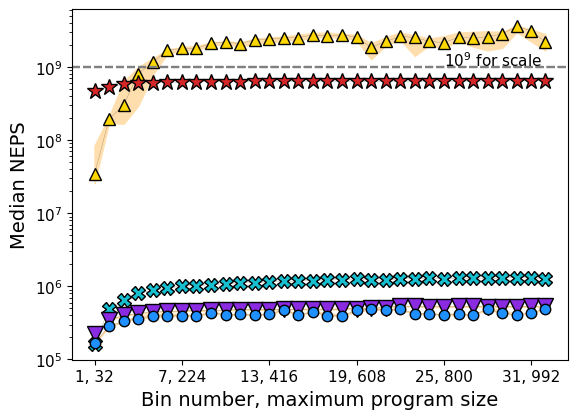



Function set nicolau_a, 100 cases...




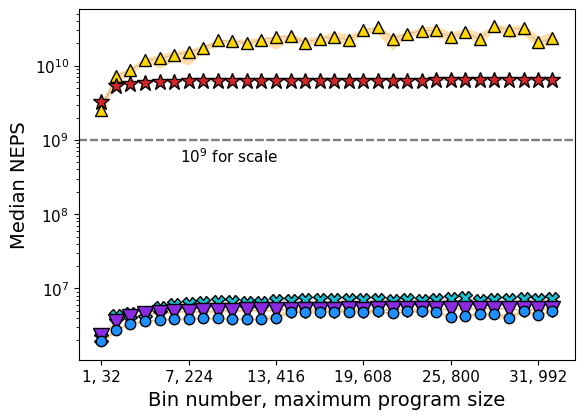



Function set nicolau_a, 1000 cases...




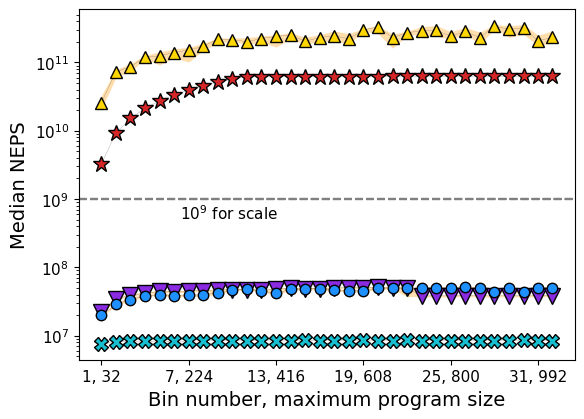

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.




Function set nicolau_a, 10000 cases...




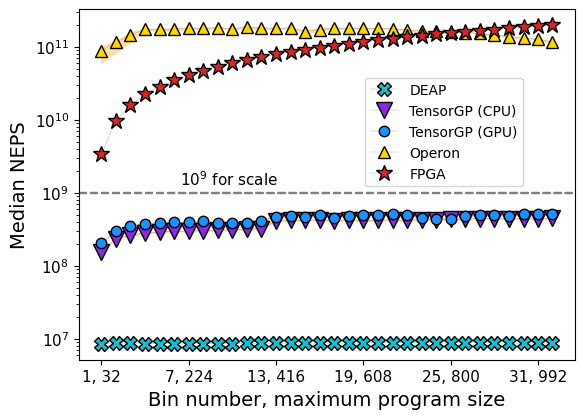



Function set nicolau_a, 100000 cases...




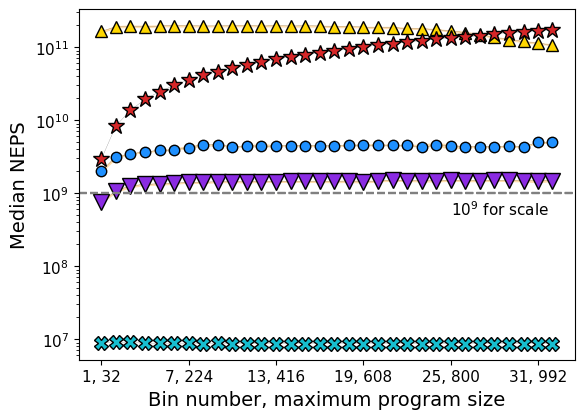



Function set nicolau_b, 10 cases...




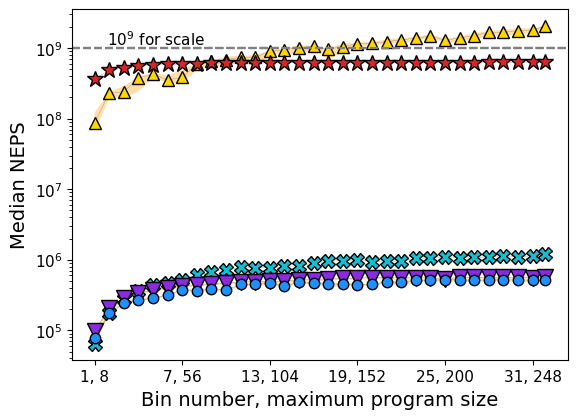



Function set nicolau_b, 100 cases...




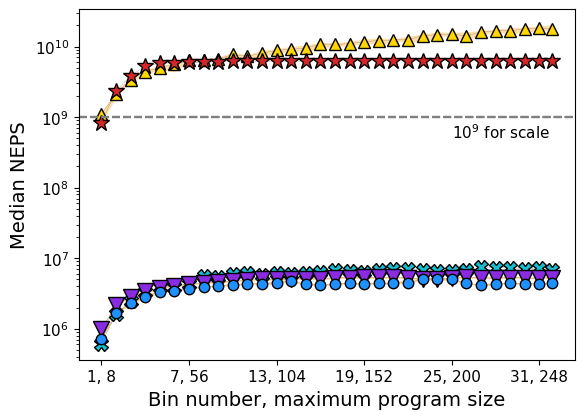



Function set nicolau_b, 1000 cases...




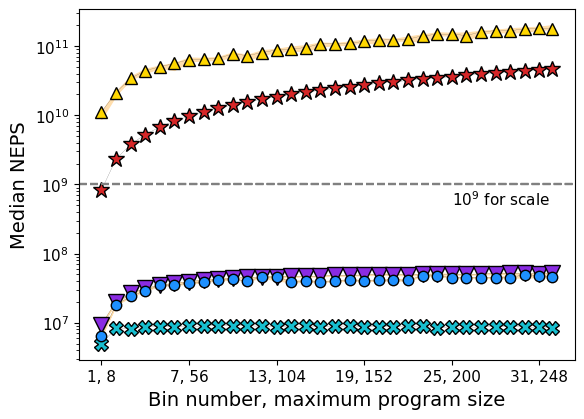



Function set nicolau_b, 10000 cases...




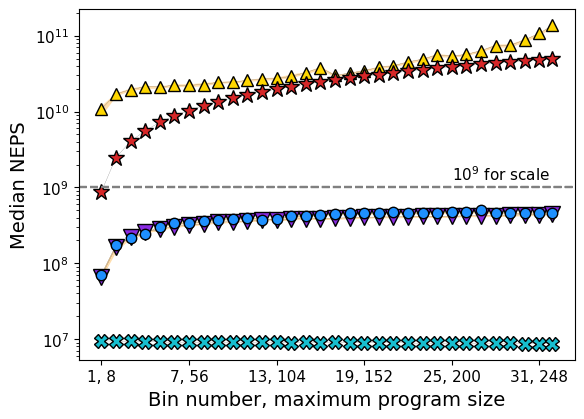



Function set nicolau_b, 100000 cases...




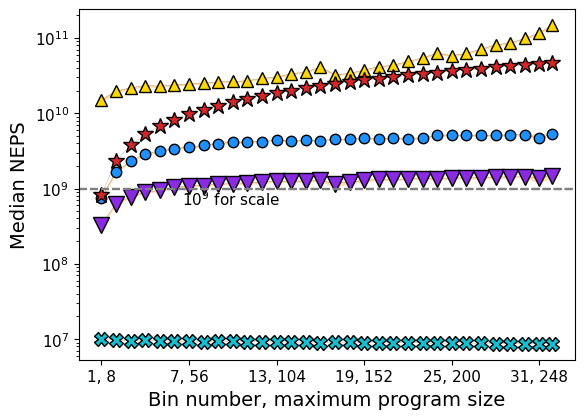



Function set nicolau_c, 10 cases...




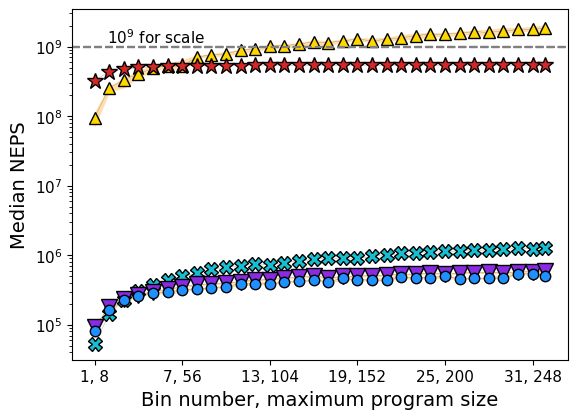



Function set nicolau_c, 100 cases...




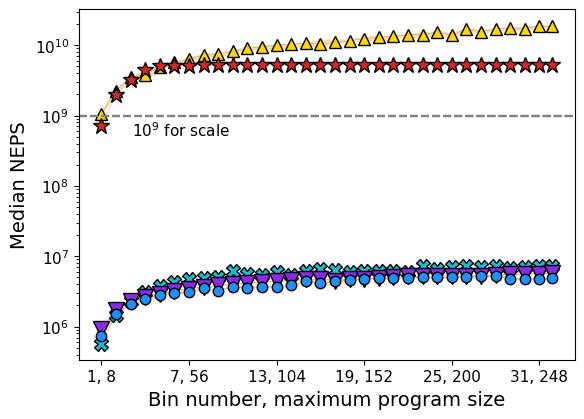



Function set nicolau_c, 1000 cases...




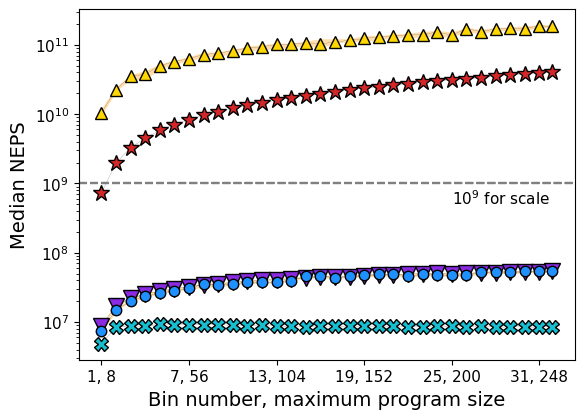



Function set nicolau_c, 10000 cases...




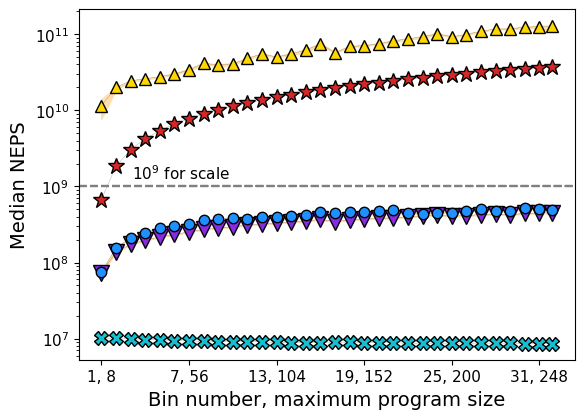



Function set nicolau_c, 100000 cases...




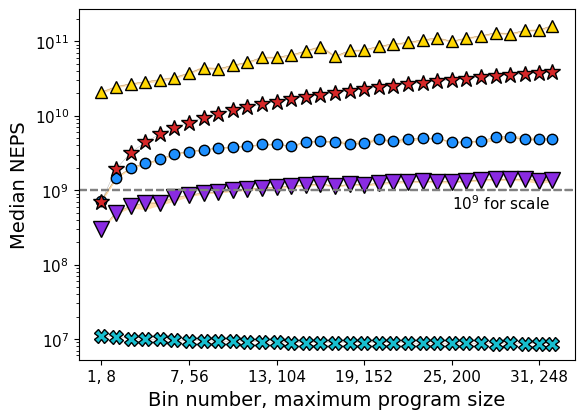

In [6]:
colors = ('tab:cyan', 'blueviolet', 'dodgerblue', 'gold', 'tab:red')
markers = ('X', 'v', '.', '^', '*')
marker_sizes = (10, 11, 15, 9, 12)
print_legend = ((False, False, False, True, False),
                (False, False, False, False, False),
                (False, False, False, False, False))
scale_text_x = ((800, 205, 205, 205, 800),
                (15, 200, 200, 200, 52),
                (15, 25, 200, 25, 200))
scale_text_y = ((1.02e9, 0.5e9, 0.5e9, 1.25e9, 5e8),
                (1.1e9, 0.5e9, 0.5e9, 1.25e9, 6e8),
                (1.1e9, 0.5e9, 0.5e9, 1.25e9, 5.5e8))

for j, ((name, ps), d_) in enumerate(zip(primitive_sets.items(), d)):
    # For each primitive set...

    # Maximum possible program size for the given depth constraint.
    s_max_possible = Program.max_size(ps.m, d_)

    # Number of unique sizes per program bin (except possibly the last).
    n_sizes = math.ceil(s_max_possible / n_bins)

    # Indices for the plots associated with the current primitive set.
    index = [s_max_possible if i == n_bins - 1 else (i + 1) * n_sizes
        for i in range(n_bins)]
    index_ = [i for i in range(1, n_bins + 1)]

    for k, nfc in enumerate(n_fitness_cases):
        # For each number of fitness cases...
        print(f'\n\nFunction set {name}, {nfc} cases...\n\n')

        for i, tool in enumerate(tools):
            # For each tool...
            x = index
            y = median_neps[i][j][k]
            
            # 25th and 75th NEPS percentiles for each program bin.
            percentile_25 = np.percentile(neps[i][j][k], 25, axis=1)
            percentile_75 = np.percentile(neps[i][j][k], 75, axis=1)
            iqr = percentile_75 - percentile_25

            plt.plot(
                x, y, label=f'{tool}', markerfacecolor=colors[i], 
                marker=markers[i], markersize=marker_sizes[i], 
                color='black', linewidth=0.1)
                # markeredgewidth=0.01, color='black', linewidth=0.1)
            plt.axhline(y=1e9, color='gray', linestyle='dashed')
            if any(iqr_ != 0 for iqr_ in iqr):
                plt.fill_between(
                    x, percentile_25, percentile_75, interpolate=True, 
                    color='navajowhite')

        plt.text(
            scale_text_x[j][k], scale_text_y[j][k], '$10^9$ for scale', 
            weight='normal', fontsize = 11)


        plt.xlabel('Bin number, maximum program size', fontsize=14)
        plt.xticks(index, [f'{str(ind_)}, {str(ind)}' 
            for ind, ind_ in zip(index, index_)], fontsize=11)
        plt.yticks(fontsize=11)
        plt.locator_params(axis='x', nbins=6)
        plt.ylabel('Median NEPS', fontsize=14)
        plt.yscale('log')
        if print_legend[j][k]:
            plt.legend(loc='best', bbox_to_anchor=(0.91, 0.65))
        plt.subplots_adjust(bottom=0.15)
        plt.savefig(
            f'{graphics_dir}/{name}/median_neps_{name}_{nfc}.eps', 
            format='eps', dpi=1200)
        plt.show()